# Example 4: Classification

## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 2, CrossEntropy loss). 

Create the two moon datatset

In [1]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()


In [2]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args_dict = {
    'grid': 5,
    #'grid': 10,
    'k': 3,
    'seed': 2024,
    'base_fun': "zero",
    'sp_trainable': False,
    'sb_trainable': False,
    'affine_trainable': False,
    'update_grid': False,
    #'base_fun': ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs'],
    #'spline_noise_scale': 0.1,
    'mode': 'default',
    #'init_mode': 'default',
    'init_mode': 'kaiming_in',
    'moon_noise': 0.0,
    'bounds': (-5,5)
}
args = Args(**args_dict)

torch.Size([1000, 2])
torch.Size([1000])


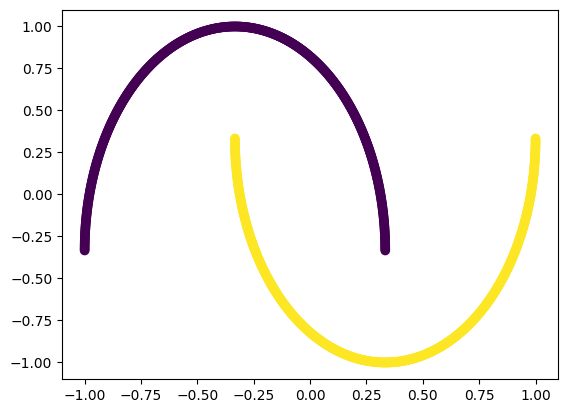

In [3]:


dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=args.moon_noise, random_state=args.seed)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=args.moon_noise, random_state=args.seed)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

# Ensure train and test inputs are in the range [-1, 1]
for key in ['train_input', 'test_input']:
    data = dataset[key]
    min_vals = data.min(dim=0, keepdim=True).values
    max_vals = data.max(dim=0, keepdim=True).values
    # Scale to [-1, 1]
    dataset[key] = 2 * (data - min_vals) / (max_vals - min_vals) - 1

# Update X as well, since it's used for plotting
X = dataset['train_input']

print(dataset['train_input'].shape)
print(dataset['train_label'].shape)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

### Train KAN

In [4]:

model = KAN(
    #width=[2,3,3,2], 
    width=[2,2,2,2,2],
    #width=[2,4,4,2], 
    #width=[2,2,2,2,2,2],  
    #width=[2,3,4,3,2], 
    #width=[2,4,8,4,2], 
    #width=[2,2,2,2,2], 
    #width=[2,3,3,2], 
    #width=[2,2,2,2,2], 
    #width=[2,5,2],
    #width=[2,2,2],
    device=device,
    #width=width, device=device,
    grid=args.grid, k=args.k, seed=args.seed,
    #sp_trainable=args.sp_trainable, sb_trainable=args.sb_trainable, affine_trainable=args.affine_trainable,
    base_fun=args.base_fun,
    #noise_scale=args.spline_noise_scale,
    mode=args.mode,
    init_mode=args.init_mode,
    #ckpt_path=ckpt_folder
    )

checkpoint directory created: ./model
saving model version 0.0


In [5]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(
    dataset, 
    opt="LBFGS", 
    steps=20, 
    metrics=(train_acc, test_acc), 
    loss_fn=torch.nn.CrossEntropyLoss(),
    update_grid=args.update_grid
    );

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 3.30e-01 | test_loss: 3.30e-01 | reg: 3.31e+01 | : 100%|█| 20/20 [00:17<00:00,  1.18it

saving model version 0.1


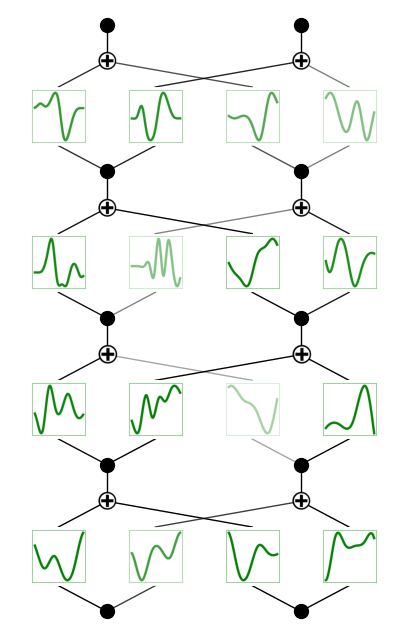

In [6]:
model.plot()

In [7]:
print("train_acc", results["train_acc"][-1])
print("test_acc", results["test_acc"][-1])

train_acc 0.9640000462532043
test_acc 0.9640000462532043


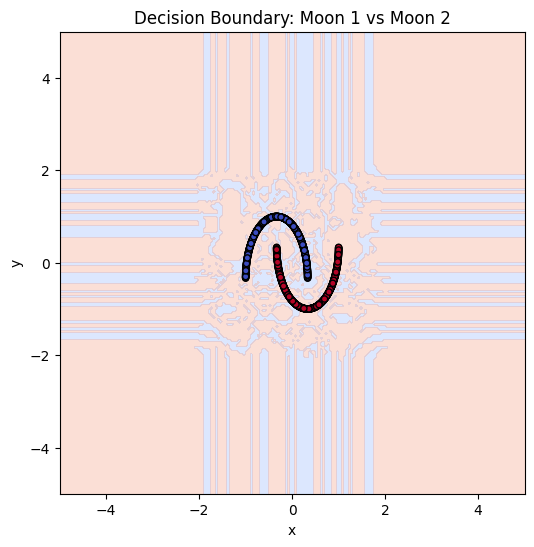

In [8]:
import torch

import matplotlib.pyplot as plt

#bounds = (-2, 3)

# Create a meshgrid in the area of the bounds
xx, yy = torch.meshgrid(
    torch.linspace(*args.bounds, 200, device=device),
    torch.linspace(*args.bounds, 200, device=device),
    indexing='ij'
)
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).type(dtype).to(device)

# Get model predictions
with torch.no_grad():
    logits = model(grid)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

# Plot the decision regions
plt.figure(figsize=(6, 6))
plt.contourf(
    xx.cpu().numpy(), yy.cpu().numpy(),
    preds.reshape(xx.shape),
    levels=1, alpha=0.3, cmap='coolwarm'
)

# Overlay the training data
X_cpu = X.cpu().numpy()
y_cpu = y.cpu().numpy()
plt.scatter(X_cpu[:, 0], X_cpu[:, 1], c=y_cpu, edgecolor='k', cmap='coolwarm', s=20)
plt.xlim(args.bounds)
plt.ylim(args.bounds)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary: Moon 1 vs Moon 2')
plt.show()

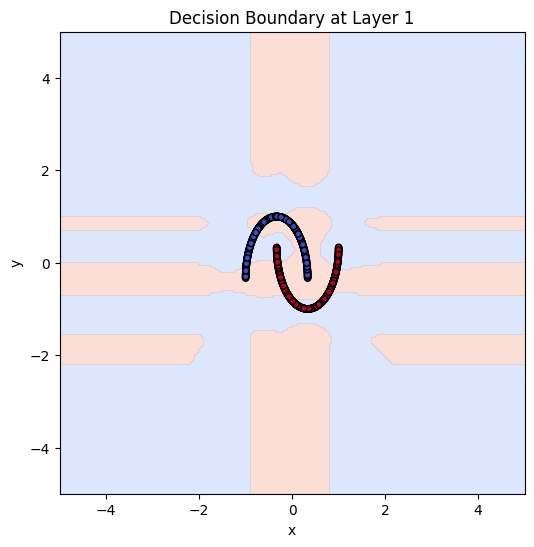

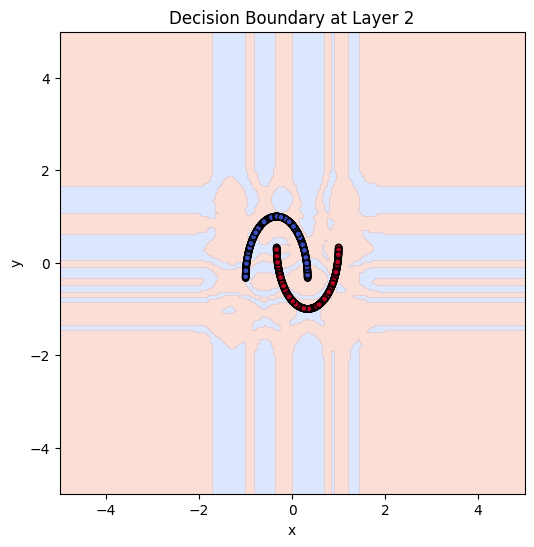

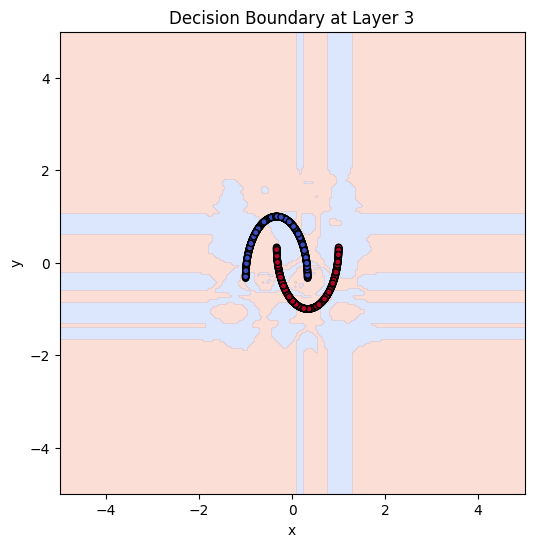

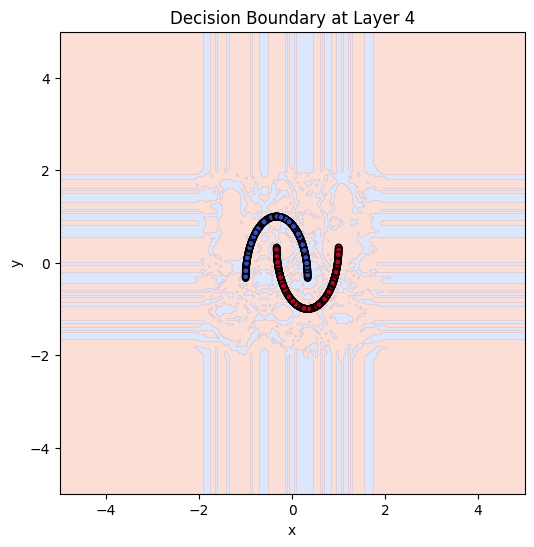

In [9]:
# Plot decision boundaries for each layer individually
import matplotlib.pyplot as plt

# Helper to get activations from each layer
def get_layer_activations(model, x):
    acts = []
    out = x
    for layer in model.act_fun:
        out, *_ = layer(out)
        acts.append(out)
    return acts

# Create meshgrid
#bounds = (-2, 3)
xx, yy = torch.meshgrid(
    torch.linspace(*args.bounds, 200, device=device),
    torch.linspace(*args.bounds, 200, device=device),
    indexing='ij'
)
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).type(dtype).to(device)

# Get activations for each layer
with torch.no_grad():
    layer_acts = get_layer_activations(model, grid)

# Plot for each layer
for i, act in enumerate(layer_acts):
    preds = torch.argmax(act, dim=1).cpu().numpy()
    plt.figure(figsize=(6, 6))
    plt.contourf(
        xx.cpu().numpy(), yy.cpu().numpy(),
        preds.reshape(xx.shape),
        levels=1, alpha=0.3, cmap='coolwarm'
    )
    plt.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c=y.cpu().numpy(), edgecolor='k', cmap='coolwarm', s=20)
    plt.xlim(args.bounds)
    plt.ylim(args.bounds)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Decision Boundary at Layer {i+1}')
    plt.show()

In [10]:
from scipy.ndimage import label

def count_islands_per_layer(layer_acts, xx):
    islands_per_layer = []
    for act in layer_acts:
        preds = torch.argmax(act, dim=1).cpu().numpy()
        mask = preds.reshape(xx.shape)
        # Label connected regions for each class and sum
        total_islands = 0
        for class_val in np.unique(mask):
            structure = np.ones((3, 3), dtype=int)
            labeled, num = label(mask == class_val, structure=structure)
            total_islands += num
        islands_per_layer.append(total_islands)
    return islands_per_layer

islands_per_layer = count_islands_per_layer(layer_acts, xx)
for idx, count in enumerate(islands_per_layer):
    print(f"Layer {idx+1}: {count} islands")

Layer 1: 9 islands
Layer 2: 31 islands
Layer 3: 28 islands
Layer 4: 143 islands


experiment: 
- input and output layer = 2.
- inner network structure: n,m and m,n respectively
- by this we create a scenario where we have the same amount of splines for deep and shallow networks

hypothesis:
deeper networks create more connected regions (islands) than shallow networks

---
Experiment 1:

width=[2,3,3,2], 
- Layer 1: 11 islands
- Layer 2: 46 islands
- Layer 3: 55 islands

width=[2,2,2,2,2], 
- Layer 1: 7 islands
- Layer 2: 24 islands
- Layer 3: 61 islands
- Layer 4: 97 islands

---
Experiment 2:

width=[2,4,4,2], 
- Layer 1: 18 islands
- Layer 2: 43 islands
- Layer 3: 41 islands

#width=[2,2,2,2,2,2], 
- Layer 1: 7 islands
- Layer 2: 1 islands
- Layer 3: 1 islands
- Layer 4: 1 islands
- Layer 5: 1 islands

---
Results:
- Experiment 1 indicates that deeper networks create more connected regions/islands
- Experiment 2 shows that deeper networks not always create more connected regions/islands
- Experiment 2 When networks get too deep, the model collapses. Maybe kaiming as initialization fixes this

---
Experiment 3:
- Kaiming initialization

width=[2,3,3,2], 
- Layer 1: 16 islands
- Layer 2: 19 islands
- Layer 3: 15 islands

width=[2,2,2,2,2],
- Layer 1: 9 islands
- Layer 2: 36 islands
- Layer 3: 62 islands
- Layer 4: 129 islands

---
Experiment 4:
- Kaiming initialization

width=[2,4,4,2], 
- Layer 1: 23 islands
- Layer 2: 51 islands
- Layer 3: 17 islands


width=[2,2,2,2,2,2], 
- Layer 1: 9 islands
- Layer 2: 25 islands
- Layer 3: 31 islands
- Layer 4: 122 islands
- Layer 5: 122 islands

---

Results: sometimes the regions/islands shrink. This is due to the resolution of xx and the bounds being bigger than (-1, 1)


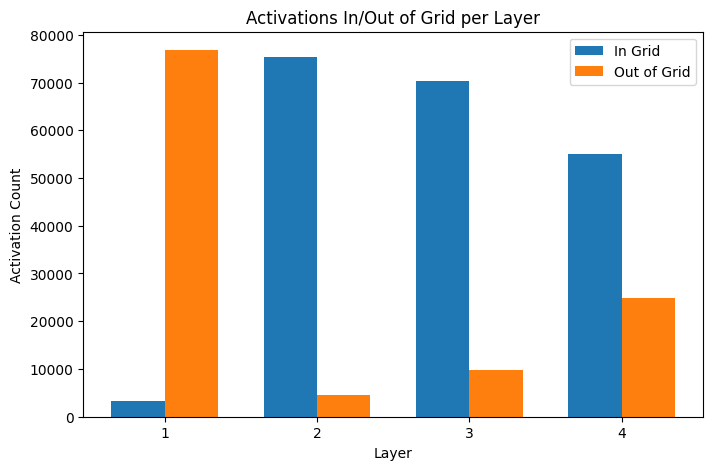

In [11]:
# Count activations within and outside the grid for each layer and plot as a barplot

in_grid_counts = []
out_grid_counts = []

# Use the same grid as in previous cells
with torch.no_grad():
    acts = [grid]
    out = grid
    for layer in model.act_fun:
        out, preacts, *_ = layer(out)
        # For each output neuron, check how many preactivations are within the grid range
        grid_min = layer.grid[:, layer.k].cpu().numpy()  # leftmost valid grid point for each input dim
        grid_max = layer.grid[:, -(layer.k+1)].cpu().numpy()  # rightmost valid grid point for each input dim
        # preacts: (num_points, out_dim, in_dim)
        preacts_np = preacts.cpu().numpy()
        in_grid = np.ones(preacts_np.shape[:2], dtype=bool)  # (num_points, out_dim)
        for in_idx in range(preacts_np.shape[2]):
            in_grid &= (preacts_np[:,:,in_idx] >= grid_min[in_idx]) & (preacts_np[:,:,in_idx] <= grid_max[in_idx])
        in_grid_count = np.sum(in_grid)
        out_grid_count = np.prod(in_grid.shape) - in_grid_count
        in_grid_counts.append(in_grid_count)
        out_grid_counts.append(out_grid_count)
        acts.append(out)

# Plotting
import matplotlib.pyplot as plt

layers = np.arange(1, len(model.act_fun)+1)
bar_width = 0.35

plt.figure(figsize=(8,5))
plt.bar(layers - bar_width/2, in_grid_counts, width=bar_width, label='In Grid')
plt.bar(layers + bar_width/2, out_grid_counts, width=bar_width, label='Out of Grid')
plt.xlabel('Layer')
plt.ylabel('Activation Count')
plt.title('Activations In/Out of Grid per Layer')
plt.xticks(layers)
plt.legend()
plt.show()